# Clustering, Dimension Reduction, PCA, TSNE

In [0]:
# Import the pandas dataframe library
import pandas as pd
import numpy as np

# Put all the plots directly into the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats

# use seaborn plotting style defaults
import seaborn as sns; sns.set()

## Introducing Principal Component Analysis

Principal Component Analysis is a very powerful unsupervised method for *dimensionality reduction* in data.  It's easiest to visualize by looking at a two-dimensional dataset:

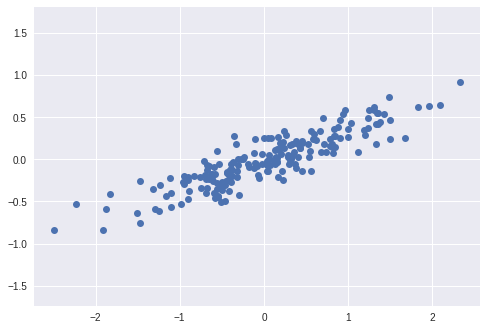

In [2]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], 'o')
plt.axis('equal'); # Choisir un seul axe : celui qui traverse tout 

We can see that there is a definite trend in the data. What PCA seeks to do is to find the Principal Axes in the data, and explain how important those axes are in describing the data distribution:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_)
print(pca.components_) # Plus on a une grande variance, plus c'est bien ! 

[0.7625315 0.0184779]
[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


To see what these numbers mean, let's view them as vectors plotted on top of the data:

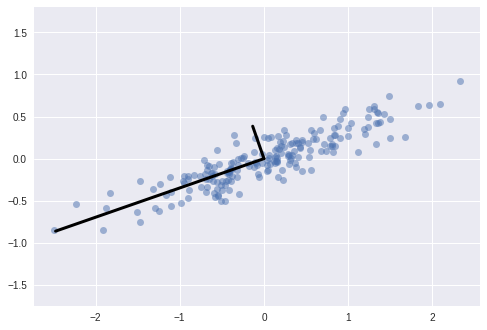

In [4]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

Notice that one vector is longer than the other. In a sense, this tells us that that direction in the data is somehow more "important" than the other direction. The explained variance quantifies this measure of "importance" in direction.

Another way to think of it is that the second principal component could be completely ignored without much loss of information! Let's see what our data look like if we only keep 95% of the variance:

In [5]:
clf = PCA(0.95) # keep 95% of variance
X_trans = clf.fit_transform(X)
print(X.shape)
print(X_trans.shape)

(200, 2)
(200, 1)


By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data look like after this compression:

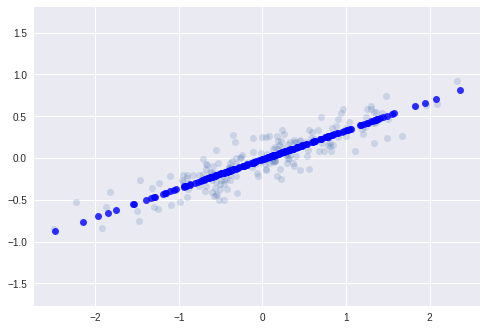

In [6]:
X_new = clf.inverse_transform(X_trans)
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version. We see that after truncating 5% of the variance of this dataset and then reprojecting it, the "most important" features of the data are maintained, and we've compressed the data by 50%!

This is the sense in which "dimensionality reduction" works: if you can approximate a data set in a lower dimension, you can often have an easier time visualizing it or fitting complicated models to the data.

### Application of PCA to Digits

The dimensionality reduction might seem a bit abstract in two dimensions, but the projection and dimensionality reduction can be extremely useful when visualizing high-dimensional data.  Let's take a quick look at the application of PCA to the digits data we looked at before:

In [0]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [8]:
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
print(X.shape)
print(Xproj.shape)

(1797, 64)
(1797, 2)


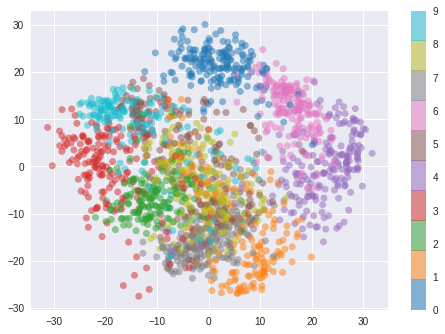

In [9]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab10', 10))
plt.colorbar();

### Choosing the Number of Components

But how much information have we thrown away?  We can figure this out by looking at the **explained variance** as a function of the components:

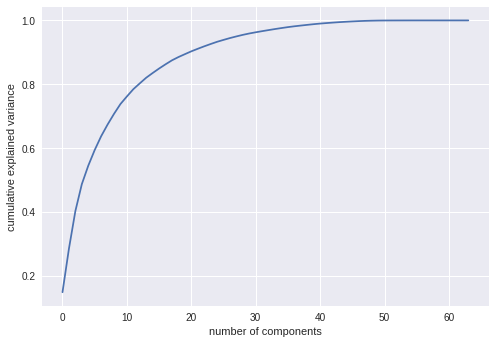

In [10]:
sns.set()
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## Other Dimensionality Reducting Routines

Note that scikit-learn contains many other unsupervised dimensionality reduction routines: some you might wish to try are
Other dimensionality reduction techniques which are useful to know about:

- [sklearn.decomposition.PCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.PCA.html): 
   Principal Component Analysis
- [sklearn.decomposition.RandomizedPCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.RandomizedPCA.html):
   extremely fast approximate PCA implementation based on a randomized algorithm
- [sklearn.decomposition.SparsePCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.SparsePCA.html):
   PCA variant including L1 penalty for sparsity
- [sklearn.decomposition.FastICA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.FastICA.html):
   Independent Component Analysis
- [sklearn.decomposition.NMF](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.NMF.html):
   non-negative matrix factorization
- [sklearn.manifold.LocallyLinearEmbedding](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html):
   nonlinear manifold learning technique based on local neighborhood geometry
- [sklearn.manifold.IsoMap](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.Isomap.html):
   nonlinear manifold learning technique based on a sparse graph algorithm
   
Each of these has its own strengths & weaknesses, and areas of application. You can read about them on the [scikit-learn website](http://sklearn.org).

# Try on a single cell RNA-seq dataset

##  Load dataset
Consider a dataset of induced pluripotent stem cells generated from three different individuals (Tung et al. 2017) in Yoav Gilad’s lab at the University of Chicago. The experiments were carried out on the Fluidigm C1 platform and to facilitate the quantification both unique molecular identifiers (UMIs) and ERCC spike-ins were used.

Download the following data
https://github.com/jdblischak/singleCellSeq/blob/gh-pages/data/molecules-final.txt

Move the data to the data directory and rename it: Tung-molecues-final.tsv

https://github.com/jdblischak/singleCellSeq

In [12]:
!wget https://github.com/jdblischak/singleCellSeq/blob/gh-pages/data/molecules-final.txt
  

--2019-01-26 00:28:24--  https://github.com/jdblischak/singleCellSeq/blob/gh-pages/data/molecules-final.txt
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘molecules-final.txt’

molecules-final.txt     [ <=>                ]  53.88K  --.-KB/s    in 0.02s   

2019-01-26 00:28:25 (3.24 MB/s) - ‘molecules-final.txt’ saved [55171]



In [14]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [15]:
!git clone https://github.com/sophiebekisz/SysBioShortCourse
 

Cloning into 'SysBioShortCourse'...
remote: Enumerating objects: 101, done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (101/101), 42.74 MiB | 27.20 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [16]:
%cd SysBioShortCourse/

/content/SysBioShortCourse


In [0]:
expression = pd.read_csv('data/Tung-molecules-final.tsv',delimiter='\t',index_col=0)

In [19]:
expression.shape

(13058, 564)

In [20]:
expression.head(5)

,NA19098.r1.A01,NA19098.r1.A02,NA19098.r1.A04,NA19098.r1.A05,NA19098.r1.A06,NA19098.r1.A07,NA19098.r1.A08,NA19098.r1.A09,NA19098.r1.A10,NA19098.r1.A11,...,NA19239.r3.H01,NA19239.r3.H03,NA19239.r3.H04,NA19239.r3.H05,NA19239.r3.H06,NA19239.r3.H07,NA19239.r3.H08,NA19239.r3.H09,NA19239.r3.H11,NA19239.r3.H12
ENSG00000237683,4.360427,4.491818,7.161884,4.346117,4.259604,4.488747,4.267879,4.302899,4.356580,4.177711,...,4.701395,4.517998,6.902736,4.520437,4.716793,4.771680,4.826392,4.874434,4.871376,4.827948
ENSG00000188976,8.439664,9.171251,8.492027,8.358237,7.393753,8.234393,8.613029,7.566827,7.862014,8.476112,...,7.865803,6.854011,7.019030,8.095158,6.919203,7.670115,8.020292,6.831985,7.816486,7.293969
ENSG00000187961,4.360427,4.487157,4.302200,4.477786,4.381080,4.600945,4.371598,4.398837,4.445352,4.259862,...,4.597922,4.416636,6.803439,4.423158,4.621487,4.678303,4.734903,7.498332,4.754608,7.042497
ENSG00000187608,6.964353,9.459715,8.542740,6.608588,8.782144,8.280604,8.650365,8.171196,7.860481,8.138603,...,7.934053,6.916979,9.432087,6.855697,8.181435,7.687599,8.424891,8.321747,8.766062,8.816385
ENSG00000188157,7.874238,8.287966,8.628105,8.514002,8.119230,8.790372,8.509128,7.756598,8.847610,7.340664,...,4.495670,8.033947,8.192498,7.422708,8.746936,8.654026,7.183016,8.897975,7.466290,6.973384


## Calculate mean and std of each gene

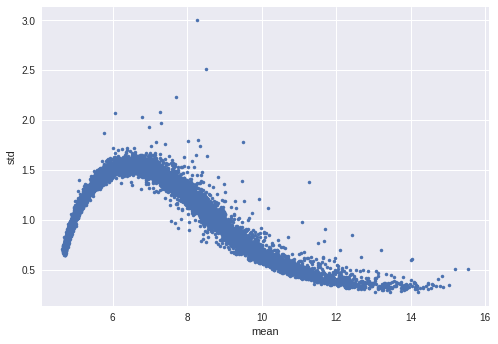

In [21]:
mu = expression.mean(axis=1)
sig = expression.std(axis=1)
plt.plot(mu,sig, '.')
plt.xlabel('mean')
plt.ylabel('std')
plt.grid(True)

##  Read meta data

In [0]:
csv = "data/GSE77288_series_matrix.txt.gz"
cell_metadata = pd.read_csv(csv, compression = 'gzip',
                                 skiprows=40, delimiter='\t',
                                 index_col=0)
print(cell_metadata.shape)
cell_metadata.head()

To correlate columns of dataframes in pandas, you use the function `.corr`. Let's look at the documentation of `.corr`

1. Is the default method Pearson or Spearman correlation? 
2. Can you correlate between rows, or only between columns?

In [0]:
help(expression.corr)

### Exercise

Use `.corr` to calculate the **Spearman** correlation of the transposed expression dataframe. Make sure to `print` the `shape`, and show the `head` of the resulting dataframe.

In [0]:
expression_corr = expression.corr(method='pearson')
print(expression_corr.shape)
expression_corr.head()

### Make a heatmap!!

Now we are ready to make a clustered heatmap! We'll use `seaborn`'s `sns.clustermap`. Let's read the documentation for `sns.clustermap`. What is the default distance metric and linkage method?

In [0]:
help(sns.clustermap)


### Exercise

Now run `sns.clustermap` on expression correlation matrices, since they are equal :)

In [0]:
sns.clustermap(expression_corr)

## Dimension reduction

In [0]:
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.manifold import TSNE, MDS

## PCA

In [0]:
pcaer = PCA(n_components=15)

In [0]:
pcad = pcaer.fit_transform(expression.T)
pcad.shape

In [0]:
pcad_df = pd.DataFrame(pcad, index=expression.T.index)
print(pcad_df.shape)
pcad_df.head()

In [0]:
plt.plot(pcad_df[0].values, pcad_df[1].values, '.')

## TSNE Visualization

In [0]:
%%time

smusher = TSNE()
tsned = smusher.fit_transform(pcad_df)
print(tsned.shape)
tsned

In [0]:
tsned.shape

In [0]:
plt.plot(tsned[:,0], tsned[:,1], '.')